In [1]:
import feather
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
import math
from multiprocessing import Pool, cpu_count
from datetime import date
import kydb
from ml.train_sequence import TrainSequence
%matplotlib inline

In [2]:
start_date = date(2019, 6, 1)
end_date = date(2020, 6, 1)
db = kydb.connect('dynamodb://epython/timeseries')
ts = db['/symbols/ml/training_data/FX_BTC_JPY']
pos_df = ts.curve(start_date, end_date)

In [3]:
model_file = 'fx_btc_jpy_model.h5'
db = kydb.connect('s3://epython')
model_data = db['/ml/models/' + model_file]
local_path = '/tmp/' + model_file
with open(local_path, 'wb') as f:
    f.write(model_data)
    
model = load_model(local_path)

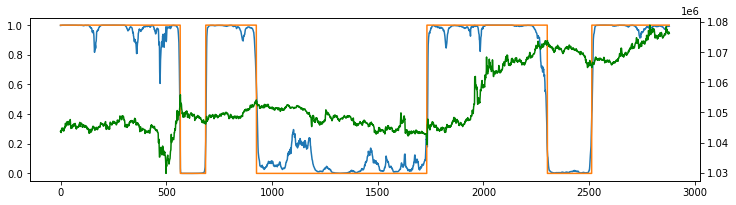

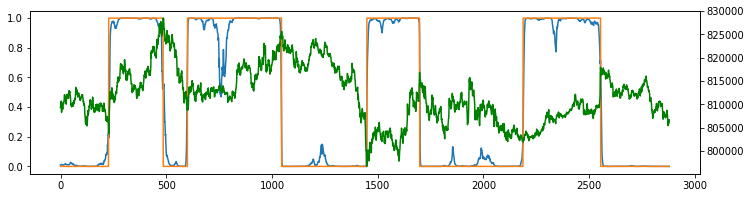

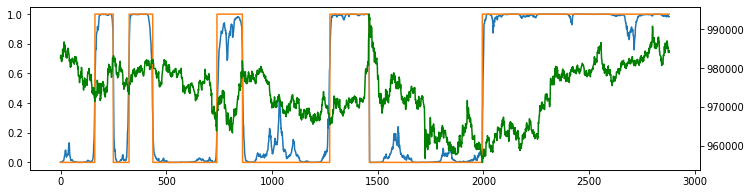

In [4]:
def get_batch(args):
    idx, seq = args
    return seq[idx]

def plot_actual_vs_predict(model, t1, t2):
    seq = TrainSequence(pos_df[t1:t2].reset_index()[['mid', 'position']].copy(), enable_shuffle=False)
    p = Pool(cpu_count())
    batches = p.map(get_batch, enumerate([seq] * len(seq)))

    xs = np.concatenate([batches[i][0] for i in range(len(seq))])
    ys = np.concatenate([batches[i][1] for i in range(len(seq))])
    y_pred = model.predict(xs)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 3)
    ax1.plot(y_pred[:, 1])
    ax1.plot(ys)
    
    df = pos_df[t1+60*24:t2]
    ax2=ax1.twinx()
    df.reset_index().mid.plot(ax=ax2, style='g-')
    
def plot_by_starting_month(month):
    start_time = month*30*24*60
    t1, t2 = start_time-60*24, start_time+60*24*2
    plot_actual_vs_predict(model, t1, t2)

for m in (3, 6, 9):
    plot_by_starting_month(m)

In [5]:
db = kydb.connect('dynamodb://epython/timeseries')
ts = db['symbols/bitflyer/minutely/FX_BTC_JPY']
md = ts.curve(date(2020, 6, 5), date(2020, 9, 5))
md.sort_index(inplace=True)

In [6]:
# Let's make it exactly 91 days
md = md[:91 * 60 * 24]

In [7]:
## Greate a sequence based on the market data loaded above. Be sure not to shuffle the data.
valid_data = md.reset_index().copy()
valid_data['position'] = 0
valid_seq = TrainSequence(valid_data, enable_shuffle=False, batch_size=60*24)

In [8]:
# Run the data through the model
ys_predict = model.predict(valid_seq, use_multiprocessing=True, workers=cpu_count())

In [9]:
# Calculate position and PNL
pnl_df = md[60*24:].copy()
pos = ys_predict[:, 1]
pnl_df['position'] = np.where(pos > 0.5, 1, -1)
pnl_df = pnl_df.join(pnl_df[['mid', 'position']].shift(), rsuffix='_prev')
pnl_df = pnl_df.iloc[1:].copy()
pnl_df['trade'] = pnl_df.position - pnl_df.position_prev
pnl_df.loc[pnl_df.index[0], 'trade'] = pnl_df.loc[pnl_df.index[0], 'position']
pnl_df['pnl'] = pnl_df.position_prev * (pnl_df.mid - pnl_df.mid_prev) - \
                pnl_df.trade * (pnl_df.ask - pnl_df.bid) / 2.
pnl_df['pnl'] = pnl_df.pnl.cumsum()

In [10]:
## Num trades
pnl_df[pnl_df.trade != 0].shape[0]

1757

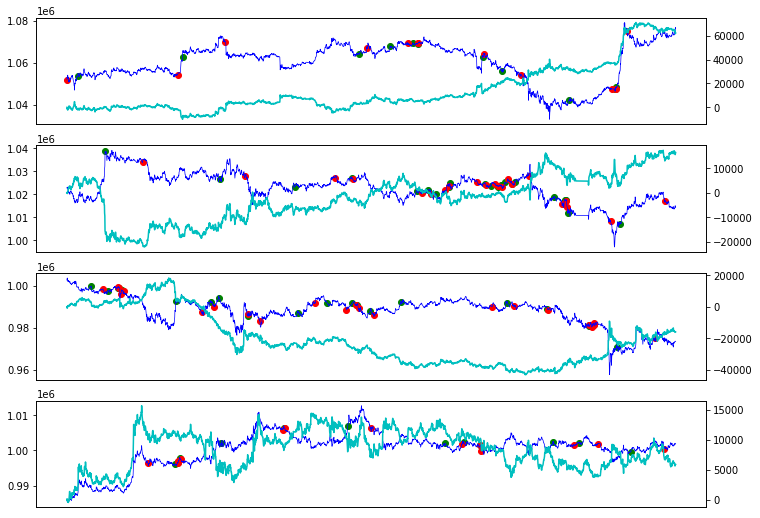

In [11]:
def plot_trades(start_day, graph_num):    
    plt.subplot(4,1,graph_num)
    #fig, ax1 = plt.subplots()#nrows=1, ncols=2, sharex=True)
    #fig, ax1 = plt.subplots()
    ax1=plt.gca()
    start_date = start_day * 60 * 24
    end_date = start_date + 60 * 24 * 2
    df = pnl_df[start_date:end_date]
    
    df[df.trade > 0.5].mid.plot(ax=ax1, style='go')    
    df[df.trade < -0.5].mid.plot(ax=ax1, style='ro')            
    ax1.get_xaxis().set_visible(False)
    ax2 = ax1.twinx()
    df.mid.plot(ax=ax1, style='b-', linewidth=0.7)
    (df.pnl - df.loc[df.index[0], 'pnl']).plot(ax=ax2, style='c-') 
    ax2.get_xaxis().set_visible(False)


plt.figure(figsize=(12,10))

for i, d in enumerate((0, 10, 20, 30)):
    plot_trades(d, i+1)

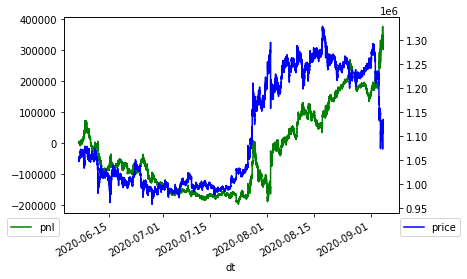

In [12]:
fig, ax1 = plt.subplots()
pnl_df.pnl.plot(ax=ax1, style='g', label='pnl')
ax1.legend(bbox_to_anchor=(0, 0), ncol=2)
ax2 = ax1.twinx()
pnl_df.mid.plot(ax=ax2, style='b', label='price')
ax2.legend(bbox_to_anchor=(1.2, 0), ncol=2)